<h1><center> NOTEBOOK COMMUN



# **Preparation**

In [1]:
## > LIBRARIES
import os
import re
import numpy as np 
import pandas as pd 
import seaborn as sns

In [2]:
## > Import packages
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle 
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# **Data** 

*C'est le Dataset dans le fichier Stage 1. Vous devez faire upload et mettre les fichiers csv necessaires. Pensez aussi à mettre le ficher MSampleSubmissionStage1_2020.*

In [3]:
## > DATA
path_datasets = './data/MDataFiles_Stage1/'

df_regular_compact = pd.read_csv(path_datasets + 'MRegularSeasonCompactResults.csv')
df_regular_detailed = pd.read_csv(path_datasets + 'MRegularSeasonDetailedResults.csv')
df_teams = pd.read_csv(path_datasets + 'MTeams.csv')
df_seeds = pd.read_csv(path_datasets + 'MNCAATourneySeeds.csv')
coaches = pd.read_csv(path_datasets + 'MTeamCoaches.csv')
df_tourney_compact = pd.read_csv(path_datasets + 'MNCAATourneyCompactResults.csv')
df_tourney_detailed = pd.read_csv(path_datasets + 'MNCAATourneyDetailedResults.csv')
df_seasons = pd.read_csv(path_datasets + 'MSeasons.csv')

In [4]:
# add match type
df_regular_detailed["Type"] = "regular"
df_tourney_detailed["Type"] = "tourney"

# combine data
df_match_detailed = pd.concat([df_regular_detailed, df_tourney_detailed])

# We createget match id: team1_team2(team1 < team2)
df_match_detailed["Match"] = df_match_detailed \
                                .apply(lambda row: "_".join(map(str, sorted([row["WTeamID"], row["LTeamID"]]))), axis=1)

df_match_detailed["Team1"] = df_match_detailed["Match"].apply(lambda x: int(x.split("_")[0]))
df_match_detailed["Team2"] = df_match_detailed["Match"].apply(lambda x: int(x.split("_")[1]))

df_match_detailed["Label"] = df_match_detailed.apply(lambda row: 1 if row["WTeamID"] == row["Team1"] else 0, axis=1)

# WLoc to numeric type
df_match_detailed["WLoc"] = df_match_detailed["WLoc"].map({"H": 0, "A": 1, "N": 3})
df_match_detailed["Type"] = df_match_detailed["Type"].map({"regular": 0, "tourney": 1})

In [5]:
df_match_detailed.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',
       'Type', 'Match', 'Team1', 'Team2', 'Label'],
      dtype='object')

# **Metrics for a given team at a given season**

**Useful functions**

In [19]:
# This functions takes as inputs the main metrics dataframe, a year offset and the column on which to apply this offset
# It returns the main metrics dataframe with the mean of the metric for the past offset years for the selected column
def mean_year_offset_metric(df_no_offset, offset, columns):
    df_offset = pd.DataFrame()

    for season in df_seasons.Season:
        df_offset_season = df_no_offset.loc[(df_no_offset.Season < season)& (df_no_offset.Season >= season-offset)].groupby(by="TeamID").mean()
        df_offset_season = df_offset_season[columns]
        df_offset_season["Season"] = season
        df_offset = pd.concat([df_offset, df_offset_season], join="outer")
    return df_offset.reset_index()

### METRIQUES LUC

 **Win rate**

In [11]:
%%time
### Creation of a Dataframe with the win rate for a given team at a given season 
# win rate = number of wins / number of match 
# win rate = nan if no match for this season and this team

#We copy the useful column to speed up the data extraction
df_match_detailed_utils = df_match_detailed[['Season', 'Team1', 'Team2','Label']].copy()

def get_win_rate(df, team):
    label_as_team1 = df.loc[(df['Team1']==team)]['Label']
    label_as_team2 = df.loc[(df['Team2']==team)]['Label']
    
    num_match = label_as_team1.size + label_as_team2.size
    # if team is team1, then it wins if label = 1
    # if team is team2, then it wins if label = 0
    num_wins = label_as_team1.loc[label_as_team1 == 1].size + label_as_team2.loc[label_as_team2 == 0].size

    #return num_wins/num_match
    if num_match == 0:
        return np.nan
    else :
        return num_wins/num_match

# We create the dataframe with Season, TeamID keys and win_rate
new_line = []
for season in df_seasons['Season'] :
    print(season)
    df_season_temp = df_match_detailed_utils[df_match_detailed_utils['Season']==season]
    for team in df_teams['TeamID']:
        win_rate = get_win_rate(df_season_temp, team)
        new_line.append([season, team, win_rate])

df_win_rate = pd.DataFrame(new_line, columns = ['Season', 'TeamID','win_rate'])

1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
CPU times: user 20.7 s, sys: 76.8 ms, total: 20.8 s
Wall time: 20 s


In [20]:
df_win_rate_store = df_win_rate


In [21]:
df_win_rate = mean_year_offset_metric(df_win_rate_store, 3, ['win_rate'])


In [22]:
df_win_rate

,TeamID,win_rate,Season
0,1101,NaN,1986
1,1102,NaN,1986
2,1103,NaN,1986
3,1104,NaN,1986
4,1105,NaN,1986
...,...,...,...
12840,1463,0.610427,2020
12841,1464,0.292361,2020
12842,1465,0.461538,2020
12843,1466,0.241379,2020


**Mean scored and conceded points per match**

In [23]:
%%time
### Creation of a Dataframe with the mean scored points and conceded points per match per team per season#We copy the useful column to speed up the data extraction
df_match_detailed_utils = df_match_detailed[['Season', 'WTeamID', 'LTeamID', 'WScore', 'LScore']].copy()

def get_mean_points_eric(df, team):
    points_as_WTeam = df.loc[(df['WTeamID']== team)][['WScore', 'LScore']]
    points_as_LTeam = df.loc[(df['LTeamID']== team)][['WScore', 'LScore']]
    
    if ((points_as_WTeam.shape[0]==0) and (points_as_LTeam.shape[0]==0)):
        return (np.nan, np.nan)
        
    else :
        conceded_points = (points_as_WTeam["LScore"].sum()+points_as_LTeam["WScore"].sum())/(points_as_WTeam.shape[0] + points_as_LTeam.shape[0])
        scored_points = (points_as_WTeam["WScore"].sum() + points_as_LTeam["LScore"].sum())/(points_as_WTeam.shape[0] + points_as_LTeam.shape[0])    
        return (scored_points, conceded_points)


# We create the dataframe with Season and TeamID keys, scored_points and conceded_points
                
new_line_scored = []
new_line_conceded = []

for season in df_seasons['Season']:
    #print(season)
    df_season_temp = df_match_detailed_utils[df_match_detailed_utils["Season"]==season]
    for team in df_teams['TeamID']:
        mean_scored_points, mean_conceded_points = get_mean_points_eric(df_season_temp, team)
        new_line_scored.append([season,team,mean_scored_points])
        new_line_conceded.append([season, team, mean_conceded_points])
    
df_points_scored = pd.DataFrame(new_line_scored, columns = ['Season', 'TeamID', 'mean_scored_points'])
df_points_conceded = pd.DataFrame(new_line_conceded, columns = ['Season', 'TeamID', 'mean_conceded_points'])


CPU times: user 26.3 s, sys: 23.7 ms, total: 26.4 s
Wall time: 25.7 s


In [25]:
offset = 3
df_points_scored = mean_year_offset_metric(df_points_scored, offset, ['mean_scored_points'])
df_points_conceded = mean_year_offset_metric(df_points_conceded, offset, ['mean_conceded_points'])


### Metriques HMENOU

### Metriques KOSTIA

**Nombre de rebond en moyenne par match de chaque équipe sur chaque saison**

In [26]:
df_tmp = df_match_detailed[["Season", "WTeamID", "LTeamID", "WDR" , "LDR", "WOR", 'LOR']]
df_rebound_count_metric = pd.DataFrame(columns=["Season", "TeamID", "rebound_count"])
for season in df_tmp.Season.unique():
    df_season = df_tmp.loc[df_tmp.Season == season]
    for team in df_teams.TeamID.unique():
        rebound_count_win = df_season[["WDR", "WOR"]].loc[df_season.WTeamID == team].mean().sum()
        rebound_count_lose = df_season[["LDR", "LOR"]].loc[df_season.LTeamID == team].mean().sum()
        new_line = pd.DataFrame({"Season":[season], 
                                 "TeamID":[team], 
                                 "rebound_count":[rebound_count_win + rebound_count_lose]})                                                                 
        df_rebound_count_metric = df_rebound_count_metric.append(new_line, ignore_index=True)

In [27]:
df_rebound_count_metric.head()

,Season,TeamID,rebound_count
0,2003,1101,0.000000
1,2003,1102,42.541667
2,2003,1103,59.489011
3,2003,1104,73.274510
4,2003,1105,75.639098


**Nombre de d'interceptions en moyenne par match de chaque équipe sur chaque saison**

In [28]:
df_tmp = df_match_detailed[["Season", "WTeamID", "LTeamID", "WBlk" , "LBlk", "WStl", 'LStl']]
df_intercept_count_metric = pd.DataFrame(columns=["Season", "TeamID", "intercept_count"])
for season in df_tmp.Season.unique():
    df_season = df_tmp.loc[df_tmp.Season == season]
    for team in df_teams.TeamID.unique():
        intercept_count_win = df_season[["WBlk", "WStl"]].loc[df_season.WTeamID == team].mean().sum()
        intercept_count_lose = df_season[["LBlk", "LStl"]].loc[df_season.LTeamID == team].mean().sum()
        new_line = pd.DataFrame({"Season":[season], 
                                 "TeamID":[team], 
                                 "intercept_count":[intercept_count_win + intercept_count_lose]})                                                                 
        df_intercept_count_metric = df_intercept_count_metric.append(new_line, ignore_index=True)

**Pourcentage de réussites à 3 points par match et par saison**

In [29]:
df_tmp = df_match_detailed[["Season", "WTeamID", "LTeamID", "WFGM3" , "LFGM3", "WFGA3", 'LFGA3']]
df_3_points_rate_metric = pd.DataFrame(columns=["Season", "TeamID", "3_points_rate"])
for season in df_tmp.Season.unique():
    df_season = df_tmp.loc[df_tmp.Season == season]
    for team in df_teams.TeamID.unique():
        
        three_points_made_count_win = df_season["WFGM3"].loc[df_season.WTeamID == team].mean()
        three_points_made_count_lose = df_season["LFGM3"].loc[df_season.LTeamID == team].mean()
        
        three_points_attempted_count_win = df_season["WFGA3"].loc[df_season.WTeamID == team].mean()
        three_points_attempted_count_lose = df_season["LFGA3"].loc[df_season.LTeamID == team].mean()
        
        three_points_rate = (three_points_made_count_win + three_points_made_count_lose)/ (three_points_attempted_count_win + three_points_attempted_count_lose)
        new_line = pd.DataFrame({"Season":[season], 
                                 "TeamID":[team], 
                                 "3_points_rate":[three_points_rate]})                                                                 
        df_3_points_rate_metric = df_3_points_rate_metric.append(new_line, ignore_index=True)

**Pourcentage de réussites au lancé franc par match et par saison**

In [30]:
df_tmp = df_match_detailed[["Season", "WTeamID", "LTeamID", "WFTM" , "LFTM", "WFTA", 'LFTA']]
df_free_throw_rate_metric = pd.DataFrame(columns=["Season", "TeamID", "free_throw_rate"])
for season in df_tmp.Season.unique():
    df_season = df_tmp.loc[df_tmp.Season == season]
    for team in df_teams.TeamID.unique():
        
        free_throw_made_count_win = df_season["WFTM"].loc[df_season.WTeamID == team].mean()
        free_throw_made_count_lose = df_season["LFTM"].loc[df_season.LTeamID == team].mean()
        
        free_throw_attempted_count_win = df_season["WFTA"].loc[df_season.WTeamID == team].mean()
        free_throw_attempted_count_lose = df_season["LFTA"].loc[df_season.LTeamID == team].mean()
        
        free_throw_rate = (free_throw_made_count_win + free_throw_made_count_lose)/ (free_throw_attempted_count_win + free_throw_attempted_count_lose)
        new_line = pd.DataFrame({"Season":[season], 
                                 "TeamID":[team], 
                                 "free_throw_rate":[free_throw_rate]})                                                                 
        df_free_throw_rate_metric = df_free_throw_rate_metric.append(new_line, ignore_index=True)

### Metriques MARC

### Merge all metrics in one DataFrame

In [31]:
df_metrics = df_rebound_count_metric
metrics = [df_points_conceded, df_points_scored, df_win_rate, df_intercept_count_metric, df_3_points_rate_metric, df_free_throw_rate_metric]
for metric in metrics:
    df_metrics = pd.merge(df_metrics, metric)

In [32]:
df_metrics.head()

,Season,TeamID,rebound_count,mean_conceded_points,mean_scored_points,win_rate,intercept_count,3_points_rate,free_throw_rate
0,2003,1101,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN
1,2003,1102,42.541667,NaN,NaN,NaN,16.104167,0.386952,0.651839
2,2003,1103,59.489011,NaN,NaN,NaN,19.153846,0.340024,0.735753
3,2003,1104,73.274510,NaN,NaN,NaN,20.161765,0.318412,0.713187
4,2003,1105,75.639098,NaN,NaN,NaN,23.969925,0.379061,0.719524


# Inter-team metrics (Luc)

**Average score difference between two teams, number of wins of team1 and number of wins of team2**

In [39]:
df_tmp = df_match_detailed[['Season', 'WTeamID', 'LTeamID', 'LScore', 'WScore']]

In [40]:
%%time
new_line = []

n_teams = df_teams['TeamID'].size
teams = df_teams['TeamID']

for i in range(n_teams):
    for j in range(n_teams-i):
        team1 = teams[i]
        team2 = teams[j]
        if team1 != team2 :
            win_team1 = df_tmp.loc[(df_tmp['WTeamID']== team1) & (df_tmp['LTeamID']==team2)][['WScore', 'LScore']]
            win_team2 = df_tmp.loc[(df_tmp['WTeamID']== team2) & (df_tmp['LTeamID']==team1)][['WScore', 'LScore']]

            s1 = win_team1.WScore - win_team1.LScore
            s2 = win_team2.LScore - win_team2.WScore

            n_wins_team1 = len(s1)
            n_wins_team2 = len(s2)

            #mean
            mean_diff_score = s1.append(s2).mean()
            new_line.append([team1, team2, mean_diff_score, n_wins_team1, n_wins_team2])
            
df_interteams_scores_and_wins = pd.DataFrame(new_line, columns = ['Team1', 'Team2', 'mean_diff_score', 'Team1_n_wins', 'Team2_n_wins'])




CPU times: user 4min 3s, sys: 39.9 ms, total: 4min 3s
Wall time: 4min 3s


# Metrics to features

**Season, Team metrics**

In [44]:
df_tmp = df_match_detailed[["Season", "Team1", "Team2", 'Label']]
mets = df_metrics.columns[df_metrics.columns != "Season"]
mets = mets[mets != "TeamID"]
df_metrics_1 = df_metrics.rename(columns={metric:"Team1_{}".format(metric) for metric in mets})
df_metrics_2 = df_metrics.rename(columns={metric:"Team2_{}".format(metric) for metric in mets})
df_metrics_1 = df_metrics_1.rename(columns={"TeamID":"Team1"})
df_metrics_2 = df_metrics_2.rename(columns={"TeamID":"Team2"})
df_tmp = pd.merge(left=df_tmp, right=df_metrics_1, how='left', on=['Season', 'Team1'])
df_matches = pd.merge(left=df_tmp, right=df_metrics_2, on=['Season', 'Team2'])

In [45]:
df_matches.head()



,Season,Team1,Team2,Label,Team1_rebound_count,Team1_mean_conceded_points,Team1_mean_scored_points,Team1_win_rate,Team1_intercept_count,Team1_3_points_rate,Team1_free_throw_rate,Team2_rebound_count,Team2_mean_conceded_points,Team2_mean_scored_points,Team2_win_rate,Team2_intercept_count,Team2_3_points_rate,Team2_free_throw_rate
0,2003,1104,1328,1,73.274510,NaN,NaN,NaN,20.161765,0.318412,0.713187,72.047619,NaN,NaN,NaN,21.058201,0.350408,0.683326
1,2003,1216,1328,0,72.938462,NaN,NaN,NaN,19.066667,0.334313,0.635829,72.047619,NaN,NaN,NaN,21.058201,0.350408,0.683326
2,2003,1164,1328,0,58.240642,NaN,NaN,NaN,19.256684,0.412796,0.734542,72.047619,NaN,NaN,NaN,21.058201,0.350408,0.683326
3,2003,1209,1328,0,67.400000,NaN,NaN,NaN,25.307692,0.337204,0.709986,72.047619,NaN,NaN,NaN,21.058201,0.350408,0.683326
4,2003,1280,1328,1,71.847619,NaN,NaN,NaN,23.680952,0.331767,0.674042,72.047619,NaN,NaN,NaN,21.058201,0.350408,0.683326


**Inter-teams metrics**

In [46]:
df_matches = pd.merge(left=df_matches, right = df_interteams_scores_and_wins, on= ['Team1', 'Team2'])
df_matches

,Season,Team1,Team2,Label,Team1_rebound_count,Team1_mean_conceded_points,Team1_mean_scored_points,Team1_win_rate,Team1_intercept_count,Team1_3_points_rate,...,Team2_rebound_count,Team2_mean_conceded_points,Team2_mean_scored_points,Team2_win_rate,Team2_intercept_count,Team2_3_points_rate,Team2_free_throw_rate,mean_diff_score,Team1_n_wins,Team2_n_wins
0,2003,1104,1328,1,73.274510,NaN,NaN,NaN,20.161765,0.318412,...,72.047619,NaN,NaN,NaN,21.058201,0.350408,0.683326,1.4,3,2
1,2006,1104,1328,0,72.585470,66.172874,72.170178,0.644734,22.034188,0.342074,...,71.516667,61.801862,70.742865,0.735622,19.688889,0.349061,0.723750,1.4,3,2
2,2007,1104,1328,1,76.159091,66.999348,72.578038,0.642880,21.340909,0.360566,...,71.400000,63.021944,70.222919,0.700801,22.200000,0.327747,0.718978,1.4,3,2
3,2014,1104,1328,0,65.618421,58.894571,64.648990,0.639205,22.684211,0.344606,...,73.952174,67.846102,68.584677,0.520161,19.521739,0.361225,0.751330,1.4,3,2
4,2018,1104,1328,1,71.212500,65.614594,67.385193,0.562215,23.112500,0.321212,...,77.063492,69.319401,74.700187,0.608112,22.071429,0.349740,0.745660,1.4,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43716,2019,1185,1242,0,70.005348,73.367816,73.586207,0.494253,23.315508,0.315524,...,74.930769,70.424732,81.580407,0.840283,19.984615,0.335360,0.716106,-24.0,0,1
43717,2019,1120,1242,1,66.517241,76.945248,77.656290,0.560682,25.103448,0.369049,...,74.930769,70.424732,81.580407,0.840283,19.984615,0.335360,0.716106,14.0,1,0
43718,2019,1124,1309,1,74.600000,67.744839,74.203180,0.649819,21.357143,0.330184,...,68.189744,73.130375,70.365155,0.424679,23.133333,0.337141,0.687961,40.0,1,0
43719,2019,1113,1138,0,78.296443,76.826389,78.171086,0.516098,19.075099,0.321330,...,77.701613,76.032026,79.404482,0.600560,20.419355,0.343875,0.663100,-17.0,0,1


## Tools to test features

/home/luclefort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/luclefort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/luclefort/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

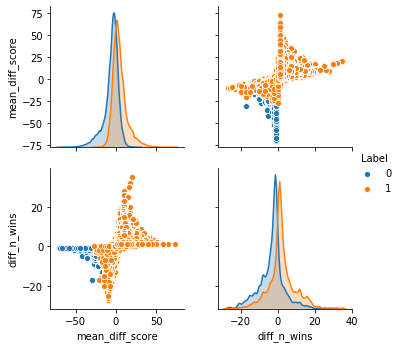

In [49]:
df_diff = df_matches[["Season", "Team1", "Team2", "Label"]]
# mets = df_metrics.columns[df_metrics.columns != "Season"]
# mets = mets[mets != "TeamID"]
# mets = mets[mets != "mean_diff_score"]
for metric in mets:
    df_diff["diff_{}".format(metric)] = df_matches["Team1_{}".format(metric)] - df_matches["Team2_{}".format(metric)]    
df_diff["diff_n_wins"] = df_matches["Team1_n_wins"] - df_matches["Team2_n_wins"]
df_diff["mean_diff_score"] = df_matches["mean_diff_score"]
sns.pairplot(df_diff, hue='Label', vars=['mean_diff_score', 'diff_n_wins'])
#sns.pairplot(df_diff,hue="Label", vars=["diff_rebound_count", "diff_intercept_count", "diff_3_points_rate", "diff_free_throw_rate", "diff_win_rate", "diff_mean_scored_points","diff_mean_conceded_points", ])

# Train et test set

In [50]:
df_matches.columns

Index(['Season', 'Team1', 'Team2', 'Label', 'Team1_rebound_count',
       'Team1_mean_conceded_points', 'Team1_mean_scored_points',
       'Team1_win_rate', 'Team1_intercept_count', 'Team1_3_points_rate',
       'Team1_free_throw_rate', 'Team2_rebound_count',
       'Team2_mean_conceded_points', 'Team2_mean_scored_points',
       'Team2_win_rate', 'Team2_intercept_count', 'Team2_3_points_rate',
       'Team2_free_throw_rate', 'mean_diff_score', 'Team1_n_wins',
       'Team2_n_wins'],
      dtype='object')

In [51]:
# Put the feature you want in train and test set
#'Team1_win_rate', 'Team2_win_rate'
selected_features = ['Team1_rebound_count', 'Team1_mean_conceded_points', 'Team1_mean_scored_points', 
                     'Team1_win_rate', 'Team1_intercept_count', 'Team1_3_points_rate', 'Team1_free_throw_rate', 
                     'Team2_rebound_count', 'Team2_mean_conceded_points', 'Team2_mean_scored_points', 
                     'Team2_win_rate', 'Team2_intercept_count', 'Team2_3_points_rate',
                     'Team2_free_throw_rate', 
                     'Team1_n_wins', 'Team2_n_wins',
                    'mean_diff_score']
df_predictions_train = df_matches[selected_features + ['Label']][(df_matches['Season']>2003)&(df_matches['Season']<2015)].copy().dropna()
df_predictions_test = df_matches[selected_features + ['Label']][df_matches['Season']>=2015].copy().dropna()


In [52]:
X_train = df_predictions_train[selected_features].values
y_train = df_predictions_train.Label.values
X_train, y_train = shuffle(X_train, y_train)
                               
X_test = df_predictions_test[selected_features].values
y_test = df_predictions_test.Label.values
X_test, y_test = shuffle(X_test, y_test)

# **Model training**

**Using XGBoost**

In [53]:
model = XGBClassifier(objective = 'binary:logistic', learning_rate=0.01, n_estimators=500) 
model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], eval_metric='logloss', verbose=True) # train


[0]	validation_0-logloss:0.690272	validation_1-logloss:0.690122
[1]	validation_0-logloss:0.687423	validation_1-logloss:0.687124
[2]	validation_0-logloss:0.684556	validation_1-logloss:0.684184
[3]	validation_0-logloss:0.681739	validation_1-logloss:0.681322
[4]	validation_0-logloss:0.679077	validation_1-logloss:0.678504
[5]	validation_0-logloss:0.67642	validation_1-logloss:0.675693
[6]	validation_0-logloss:0.673757	validation_1-logloss:0.672995
[7]	validation_0-logloss:0.67123	validation_1-logloss:0.670314
[8]	validation_0-logloss:0.668638	validation_1-logloss:0.667754
[9]	validation_0-logloss:0.666139	validation_1-logloss:0.665185
[10]	validation_0-logloss:0.663808	validation_1-logloss:0.662665
[11]	validation_0-logloss:0.661438	validation_1-logloss:0.660211
[12]	validation_0-logloss:0.65911	validation_1-logloss:0.657712
[13]	validation_0-logloss:0.656835	validation_1-logloss:0.655361
[14]	validation_0-logloss:0.654524	validation_1-logloss:0.653039
[15]	validation_0-logloss:0.652255	val

[127]	validation_0-logloss:0.536293	validation_1-logloss:0.529706
[128]	validation_0-logloss:0.535941	validation_1-logloss:0.529288
[129]	validation_0-logloss:0.535498	validation_1-logloss:0.528876
[130]	validation_0-logloss:0.535114	validation_1-logloss:0.528468
[131]	validation_0-logloss:0.534728	validation_1-logloss:0.528029
[132]	validation_0-logloss:0.534308	validation_1-logloss:0.527611
[133]	validation_0-logloss:0.533924	validation_1-logloss:0.527218
[134]	validation_0-logloss:0.533544	validation_1-logloss:0.526806
[135]	validation_0-logloss:0.533197	validation_1-logloss:0.526431
[136]	validation_0-logloss:0.532805	validation_1-logloss:0.526043
[137]	validation_0-logloss:0.532463	validation_1-logloss:0.525663
[138]	validation_0-logloss:0.532092	validation_1-logloss:0.525251
[139]	validation_0-logloss:0.531747	validation_1-logloss:0.524885
[140]	validation_0-logloss:0.531359	validation_1-logloss:0.5245
[141]	validation_0-logloss:0.531045	validation_1-logloss:0.524183
[142]	valida

[252]	validation_0-logloss:0.508154	validation_1-logloss:0.500774
[253]	validation_0-logloss:0.508006	validation_1-logloss:0.50067
[254]	validation_0-logloss:0.507915	validation_1-logloss:0.500556
[255]	validation_0-logloss:0.507815	validation_1-logloss:0.500438
[256]	validation_0-logloss:0.50765	validation_1-logloss:0.500303
[257]	validation_0-logloss:0.507558	validation_1-logloss:0.500197
[258]	validation_0-logloss:0.507441	validation_1-logloss:0.500106
[259]	validation_0-logloss:0.507339	validation_1-logloss:0.499998
[260]	validation_0-logloss:0.507233	validation_1-logloss:0.499855
[261]	validation_0-logloss:0.50709	validation_1-logloss:0.49976
[262]	validation_0-logloss:0.507025	validation_1-logloss:0.499676
[263]	validation_0-logloss:0.506875	validation_1-logloss:0.499577
[264]	validation_0-logloss:0.506771	validation_1-logloss:0.499441
[265]	validation_0-logloss:0.506687	validation_1-logloss:0.499341
[266]	validation_0-logloss:0.506554	validation_1-logloss:0.499266
[267]	validati

[377]	validation_0-logloss:0.498248	validation_1-logloss:0.491503
[378]	validation_0-logloss:0.498199	validation_1-logloss:0.491464
[379]	validation_0-logloss:0.498127	validation_1-logloss:0.491389
[380]	validation_0-logloss:0.498089	validation_1-logloss:0.491342
[381]	validation_0-logloss:0.498033	validation_1-logloss:0.491321
[382]	validation_0-logloss:0.497991	validation_1-logloss:0.491292
[383]	validation_0-logloss:0.497922	validation_1-logloss:0.491223
[384]	validation_0-logloss:0.49786	validation_1-logloss:0.491162
[385]	validation_0-logloss:0.497827	validation_1-logloss:0.491132
[386]	validation_0-logloss:0.497773	validation_1-logloss:0.491096
[387]	validation_0-logloss:0.497738	validation_1-logloss:0.49107
[388]	validation_0-logloss:0.497692	validation_1-logloss:0.49103
[389]	validation_0-logloss:0.497654	validation_1-logloss:0.490999
[390]	validation_0-logloss:0.497616	validation_1-logloss:0.490975
[391]	validation_0-logloss:0.497561	validation_1-logloss:0.490956
[392]	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [54]:
model.score(X_test, y_test)

0.7202199598721855

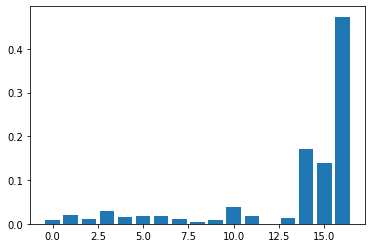

In [55]:
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

In [56]:
#evals_results = model.evals_result()
#evals_results

# Loss Kaggle

In [57]:
def logloss(true_label, predicted, eps=1e-15):
    p = np.clip(predicted, eps, 1 - eps)
    if true_label == 1:
        return -np.log(p)
    return -np.log(1 - p)

In [58]:
preds = model.predict_proba(X_test)

In [59]:
loss = 0
for i, value in enumerate(y_test):
    loss += logloss(value, preds[i,1])
loss = loss/len(y_test)
    

In [60]:
loss

0.48756473775699494

# Prediction for Kaggle Competition (to adapt to the features you choose)

Here we build a test set from the MSampleSubmissionStage1_2020 file.
Then we build a csv which has to be submitted to kaggle for score evaluation, here : https://www.kaggle.com/c/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/submit

In [346]:
df_sample_sub = pd.read_csv('./data/' + 'MSampleSubmissionStage1_2020.csv')

n_test_games = len(df_sample_sub)

#Get season, team1 and team2
def get_season_t1_t2(ID):
    return(int(x) for x in ID.split('_'))

In [347]:
X_test = np.zeros(shape = (n_test_games, 2))


for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.ID) # get year, team1, team2
    
    #win_rate_team1 = df_concat['Team1_win_rate'][(df_concat.Team1== t1) & (df_concat.Season == year)].values[0]
    #win_rate_team2 = df_concat['Team2_win_rate'][(df_concat.Team2== t2) & (df_concat.Season == year)].values[0]
    
    win_rate_team1 = df_win_rate['win_rate'][(df_win_rate.TeamID == t1) & (df_win_rate.Season == year)].values[0]
    win_rate_team2 = df_win_rate['win_rate'][(df_win_rate.TeamID == t1) & (df_win_rate.Season == year)].values[0]

    X_test[ii,0] = win_rate_team1
    X_test[ii,1] = win_rate_team2

In [350]:
preds = xgb.predict_proba(X_test)

clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub.Pred = clipped_preds[:,0]
df_sample_sub.sample

<bound method NDFrame.sample of                    ID      Pred
0      2015_1107_1112  0.523289
1      2015_1107_1116  0.523289
2      2015_1107_1124  0.523289
3      2015_1107_1125  0.523289
4      2015_1107_1129  0.523289
...               ...       ...
11385  2019_1449_1459  0.530061
11386  2019_1449_1463  0.530061
11387  2019_1458_1459  0.456799
11388  2019_1458_1463  0.456799
11389  2019_1459_1463  0.530061

[11390 rows x 2 columns]>

In [340]:
df_sample_sub.to_csv('win_rate_xgboost.csv', index = False)